In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

from sklearn.model_selection import train_test_split

import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
%pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

In [ ]:
# data (as pandas dataframes)
x = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

In [ ]:
df = pd.merge(
    x,
    y,
    how='inner',
    left_index=True, right_index=True
)
df.head(5)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Management,Severity,Diagnosis
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conservative,uncomplicated,appendicitis
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,NaN,NaN,conservative,uncomplicated,no appendicitis
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,yes,NaN,conservative,uncomplicated,no appendicitis
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,no appendicitis
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,appendicitis


In [ ]:
df = df.drop(df[df['Management'] == 'simultaneous appendectomy'].index)
df = df.drop(['Severity', 'Diagnosis'], axis=1)

In [ ]:
for column in df.select_dtypes(include=['number']).columns:
  df[column].fillna(df[column].mean(), inplace=True)
for column in df.select_dtypes(include=['object']).columns:
  df[column].fillna('no', inplace=True)

In [ ]:
df = df.drop(df[df['Management'] == 'no'].index)

In [ ]:
df['Management'].value_counts()

,count
Management,
conservative,483
primary surgical,270
secondary surgical,27


In [ ]:
y = df['Management']
x = df.drop('Management', axis=1)
x_copy = x.copy()

In [ ]:
cat_columns = x.select_dtypes(['object']).columns
x[cat_columns] = x[cat_columns].apply ( lambda x: pd.factorize (x)[ 0 ])
x=(x-x.min())/(x.max()-x.min())
x.head(5)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,0.690632,0.299044,0.0,0.683453,0.333603,0.074074,0.4,0.3,0.0,0.307692,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.767974,0.793604,0.5,0.676259,0.661753,0.037037,0.5,0.4,1.0,0.354032,...,0.0,1.0,0.038462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.770153,0.510056,0.0,0.791367,0.586026,0.111111,0.5,0.3,1.0,0.354032,...,0.0,1.0,0.038462,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.891612,0.421035,0.0,0.805755,0.525444,0.074074,0.7,0.6,1.0,0.354032,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.603486,0.299044,0.0,0.791367,0.414378,0.074074,0.5,0.6,0.0,0.300699,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
vals = y.unique()
vals

array(['conservative', 'primary surgical', 'secondary surgical'],
      dtype=object)

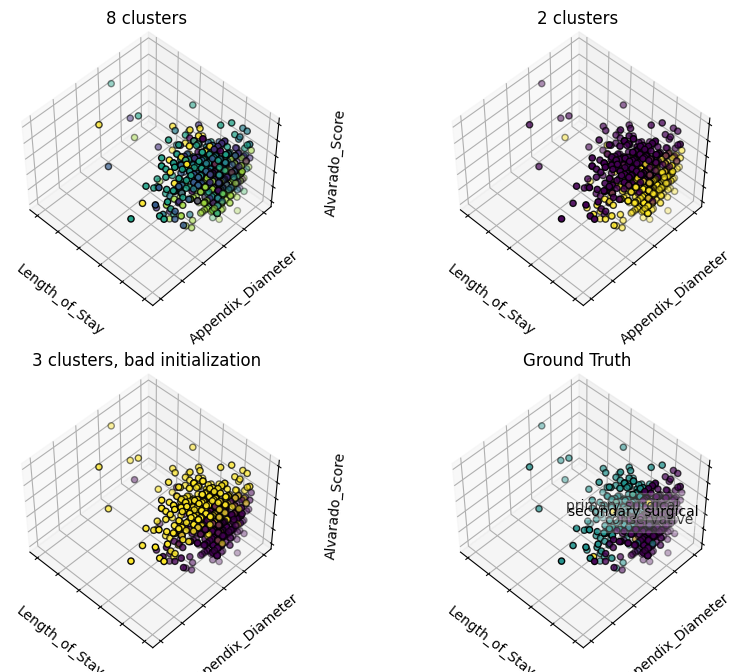

In [ ]:
X = x
estimators = [
    ("k_means_8", KMeans(n_clusters=8)),
    ("k_means_2", KMeans(n_clusters=2)),
    ("k_means_bad_init", KMeans(n_clusters=2, n_init=1, init="random")),
]

x_name="Length_of_Stay"
y_name="Appendix_Diameter"
z_name="Alvarado_Score"

fig = plt.figure(figsize=(10, 8))
titles = ["8 clusters", "2 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[x_name], X[y_name], X[z_name], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

dftemp = pd.merge(
      x,
      y,
      how='inner',
      left_index=True, right_index=True
    )

for name, label in [(vals[0], 0), (vals[1], 1), (vals[2], 2)]:

    ds = dftemp[dftemp['Management']==name]
    ax.text3D(
        ds[x_name].mean(),
        ds[y_name].mean(),
        ds[z_name].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
temp_y = y.copy()
temp_y.replace(['conservative', 'primary surgical', 'secondary surgical'],
                        [0, 1, 2], inplace=True)
ax.scatter(X[x_name], X[y_name], X[z_name], c=temp_y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)
ax.set_zlabel(z_name)
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [ ]:
n_clusters = np.arange(2, 21)

best_metric = [0, 10000, 0,[]]

silhouette_score_values = []
adjusted_rand_score_values = []

for n in n_clusters:
    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)

    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)

    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)

    if score1 < best_metric[1] and score2 > best_metric[2]:
          best_metric[1] = score1
          best_metric[2] = score2
          best_metric[3] = clusterer.cluster_centers_
          best_metric[0] = n


In [ ]:
best_metric

[2,
 0.10383187041020223,
 0.20891208305360073,
 array([[0.64722761, 0.38620903, 0.23102679, 0.69861971, 0.42269437,
         0.09588734, 0.46789235, 0.42305537, 0.44866071, 0.32170841,
         0.20535714, 0.07142857, 0.72991071, 0.22321429, 0.390625  ,
         0.66964286, 0.77794856, 0.21656744, 0.53059676, 0.55012093,
         0.15848214, 0.11262808, 0.18673044, 0.02261134, 0.31005275,
         0.39955357, 0.3266369 , 0.06175595, 0.04771111, 0.0625    ,
         0.12332589, 0.09486607, 0.68080357, 0.02678571, 0.03125   ,
         0.26785714, 0.22321429, 0.046875  , 0.50223214, 0.01636905,
         0.01934524, 0.88616071, 0.01116071, 0.00223214, 0.78125   ,
         0.09366415, 0.04910714, 0.01339286, 0.01116071, 0.06919643,
         0.1875    , 0.07366071, 0.01737883],
        [0.57794577, 0.33689683, 0.29819277, 0.66305927, 0.35968886,
         0.15640339, 0.76021824, 0.66280554, 0.22590361, 0.39764822,
         0.35843373, 0.04819277, 0.46686747, 0.35240964, 0.83433735,
         

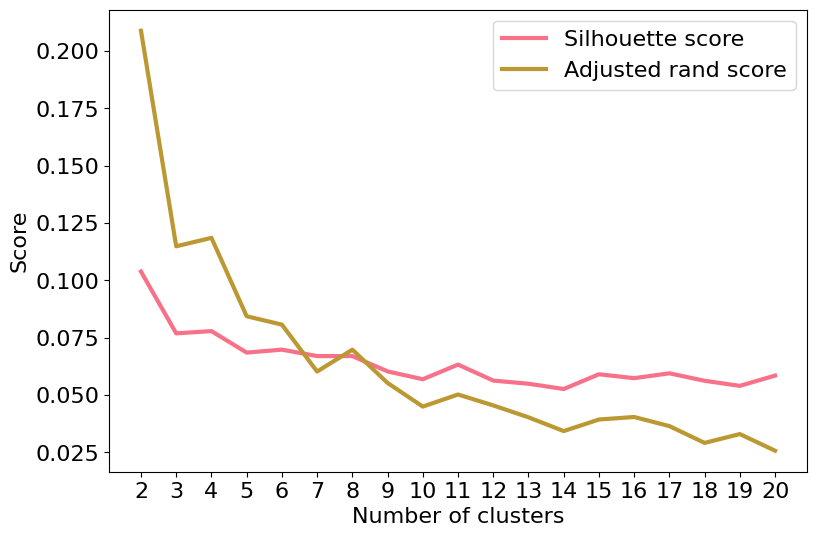

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)

plt.show()

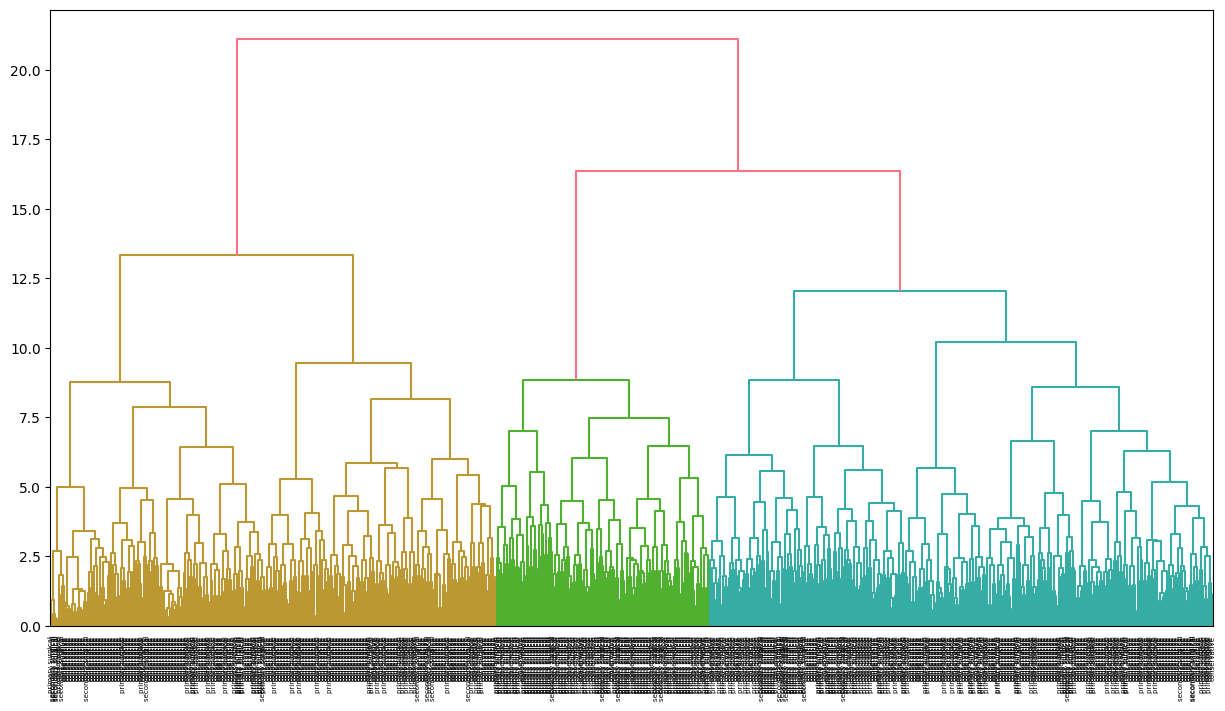

In [ ]:
samples = x.values

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
mergings = linkage(samples, method='ward')

plt.figure(figsize=(15, 8))

dendrogram(mergings,
           labels=list(y),
           leaf_rotation=90,
           leaf_font_size=5,
           )

plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [ ]:
mins = X.shape[1]

['y', 'b']


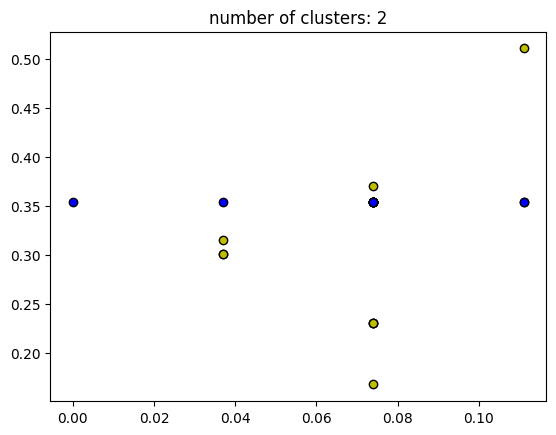

In [ ]:
db = DBSCAN(eps=0.8, min_samples=6).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['y', 'b']
print(colors)
for k, col in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		col = 'k'

	class_member_mask = (labels == k)

	xy = X[class_member_mask & core_samples_mask]
	plt.plot(xy[x_name], xy[y_name], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

	xy = X[class_member_mask & ~core_samples_mask]
	plt.plot(xy[x_name], xy[y_name], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()


Черные точки - это выбросы. Меняя значение eps и min_samples, мы можем контролировать результат работы алгоритма

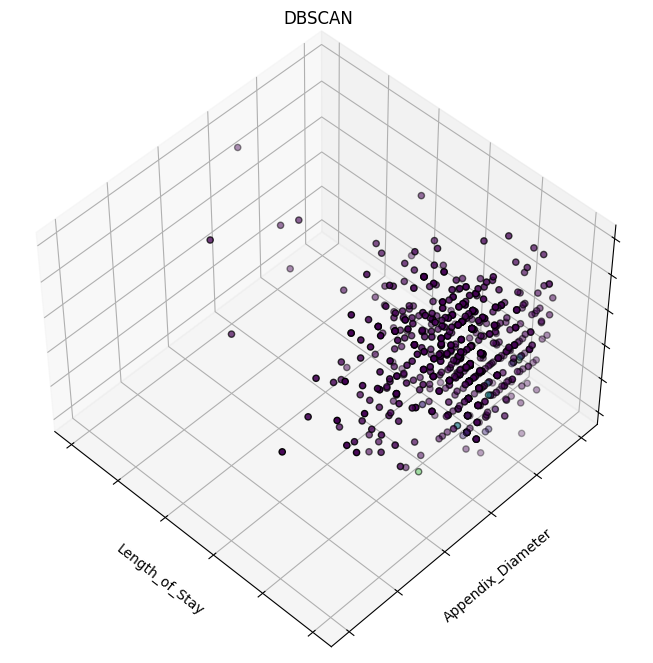

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d", elev=48, azim=134)

ax.scatter(X[x_name], X[y_name], X[z_name], c=labels.astype(float), edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)
ax.set_zlabel(z_name)
ax.set_title("DBSCAN")

plt.show()

Для оценки алгоритмов кластеризации мы будем использовать оценку силуэта и оценку скорректированного рэнда. Оценка Silhouette находится в диапазоне от -1 до 1. Оценка около 1 означает, что точка данных i очень компактна в пределах кластера, к которому она принадлежит, и удалена от других кластеров. Худшее значение — -1. Значения, близкие к 0, обозначают перекрывающиеся кластеры.

Абсолютный показатель Rand Score находится в диапазоне от 0 до 1. Больше 0,9 означает отличное кластерное восстановление, а выше 0,8 — хорошее восстановление. Менее 0,5 считается плохим восстановлением.

In [ ]:
# evaluation metrics
sc = metrics.silhouette_score(x, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index: %0.2f" % ari)

Silhouette Coefficient:-0.14
Adjusted Rand Index: -0.02
